 ## Initilization

In [27]:

import os.path as path
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch import optim
import matplotlib.pyplot as plt
import csv



In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device.type}")



device: cuda


 ## Prepare for Data

In [29]:

DATA_DIR = "./dataset"
DATA_DIR = path.abspath(DATA_DIR)

files = os.listdir(DATA_DIR)
files.sort(key=lambda x: int(x.split('_')[1]))
files.sort(key=lambda x: int(x.split('_')[0]))

event_images = []
for fn in files:
    date_slices = fn.split("_")
    
    data_file = f"{DATA_DIR}/{fn}/event_full_n.csv"
    df_np = pd.read_csv(data_file).to_numpy()

    event1_numbers = np.append(df_np[1:, 3], 0).reshape((1, 77, 68))
    event2_numbers = np.append(df_np[1:, 4], 0).reshape((1, 77, 68))
    event3_numbers = np.append(df_np[1:, 5], 0).reshape((1, 77, 68))
    event4_numbers = np.append(df_np[1:, 6], 0).reshape((1, 77, 68))
    event5_numbers = np.append(df_np[1:, 7], 0).reshape((1, 77, 68))
    event6_numbers = np.append(df_np[1:, 8], 0).reshape((1, 77, 68))

    event_image = np.concatenate((event1_numbers, event2_numbers, event3_numbers, event4_numbers, event5_numbers, event6_numbers), axis = 0)
    event_images.append(event_image)
    
event_images = torch.tensor(event_images, dtype=torch.float)

print(f"shape: {event_images.shape}")
print(f"max: {torch.max(event_images)}")



shape: torch.Size([74, 6, 77, 68])
max: 1.0


In [30]:

# reshape every 36 months (24 months for encoder, 12 months for decoder), the time window slides
TIME_WINDOW = 36
examples = []
for i in range(0, event_images.shape[0] - TIME_WINDOW):
    examples.append(event_images[i:i+TIME_WINDOW])

print(f"len(examples): {len(examples)}")
print(f"examples[0].shape: {examples[0].shape}")



len(examples): 38
examples[0].shape: torch.Size([36, 6, 77, 68])


 ## Split into Training Set and Test Set

In [31]:

train_test_ratio = 0.8 # 4/5 to be training set
train_set = []
test_set = []
for idx in range(len(examples)):
    if random.random() <= train_test_ratio:
        train_set.append(examples[idx])
    else:
        test_set.append(examples[idx])
        
print(f"training set size: {len(train_set)} examples")
print(f"testing set size: {len(test_set)} examples")



training set size: 32 examples
testing set size: 6 examples


 ## ConvLSTM Model

In [32]:

class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))



 ## Seq2Se2 ConvLSTM

In [33]:

BATCH_SIZE = 1
IMG_W = 77
IMG_H = 68
IMAGE_SIZE = (IMG_W, IMG_H)
TEACHER_FORCING_RATIO = 0.5
LEARNING_RATE=0.001
EPOCH = 10
START = torch.zeros(1, 6, 77, 68).to(device) * -1

# criterion
criterion = nn.MSELoss().to(device)

encoder = ConvLSTMCell(6, 6, (3,3), False).to(device) # input_dim, hidden_dim, kernel_size, bias
decoder = ConvLSTMCell(6, 6, (3,3), False).to(device) # input_dim, hidden_dim, kernel_size, bias

# optimizer
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()



In [34]:

def train(train_set, encoder, decoder):

    losses = []
    loader = Data.DataLoader(
        dataset=train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=4           # set multi-work num read data
    )
    
    for i, train_imgs in enumerate(loader):
        if i%10 == 0:
            print(" . ", end="")
        
        # input seq
        input_images = train_imgs[:, :24, :, :, :].to(device) # (b, 24, 6, 77, 68)
        # target seq
        target_images = train_imgs[:, 24:, :, :, :].to(device) # (b, 12, 6, 77, 68)

        loss = 0
        
        # initilize first hidden states of encoder
        encoder_h, encoder_c = encoder.init_hidden(input_images.shape[0], IMAGE_SIZE)
        for idx in range(input_images.shape[1]):
            input_img = input_images[:, idx, :, :, :]
            encoder_h, encoder_c = encoder(input_img, (encoder_h, encoder_c))

        # out seq
        output_images = torch.zeros((input_images.shape[0], 12, 6, 77, 68))
        decoder_h, decoder_c = decoder(START, (encoder_h, encoder_c))
        for idx in range(output_images.shape[1]):
            use_teacher_forcing = True if random.random() < TEACHER_FORCING_RATIO else False
            if idx != 0 and use_teacher_forcing:
                # Teacher Forcing: Feed the target as the next input
                input_img = target_images[:, idx - 1, :, :, :]
                decoder_h, decoder_c = decoder(input_img, (decoder_h, decoder_c)) # teacher forcing
            
            else:
                # Without teacher forcing: use its own predictions as the next input
                decoder_input = decoder_h.detach() # detach from history as input
                decoder_h, decoder_c = decoder(decoder_input, (decoder_h, decoder_c))

            output_images[:, idx, :, :, :] = decoder_h
            loss += criterion(decoder_h, target_images[:, idx, :, :, :])

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(encoder.parameters(), clip_value=0.5)
        nn.utils.clip_grad_value_(decoder.parameters(), clip_value=0.5)
        encoder_optimizer.step()
        decoder_optimizer.step()

        losses.append(loss.item() / TIME_WINDOW / BATCH_SIZE)
        
    return losses



In [35]:
torch.cuda.empty_cache()
encoder.train()
decoder.train()
losses = []
for epoch in range(EPOCH):
    print(f"EPOCH: {epoch+1}/{EPOCH}")
    loss = train(train_set, encoder, decoder)
    losses += loss
    print("")



EPOCH: 1/10
 .  .  .  . 
EPOCH: 2/10
 .  .  .  . 
EPOCH: 3/10
 .  .  .  . 
EPOCH: 4/10
 .  .  .  . 
EPOCH: 5/10
 .  .  .  . 
EPOCH: 6/10
 .  .  .  . 
EPOCH: 7/10
 .  .  .  . 
EPOCH: 8/10
 .  .  .  . 
EPOCH: 9/10
 .  .  .  . 
EPOCH: 10/10
 .  .  .  . 


 ## Plot Training Loss

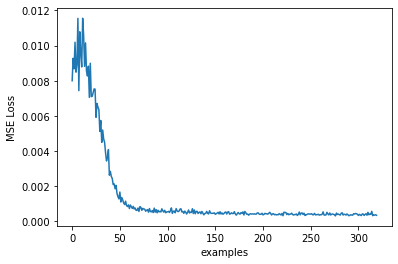

In [36]:

plt.plot(losses)
plt.ylabel('MSE Loss'), plt.xlabel('examples')
plt.show()



 ## Testing

 . 

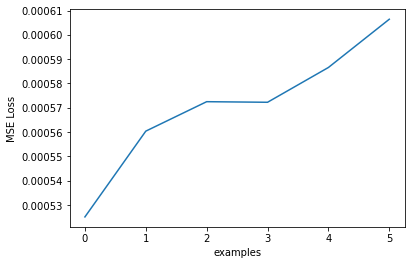

In [37]:
encoder.eval()
decoder.eval()
    
with torch.no_grad():
    losses_test = []
    for i, test_imgs in enumerate(test_set):  
        if i%100 == 0:
            print(" . ", end="")

        test_imgs = test_imgs.unsqueeze(0)
        # input seq
        input_images = test_imgs[:, :24, :, :, :].to(device) # (1, 24, 6, 77, 68)
        # target seq
        target_images = test_imgs[:, 24:, :, :, :].to(device) # (1, 12, 6, 77, 68)

        loss = 0
        
        # initilize first hidden states of encoder
        encoder_h, encoder_c = encoder.init_hidden(input_images.shape[0], IMAGE_SIZE)
        for idx in range(input_images.shape[1]):
            input_img = input_images[:, idx, :, :, :]
            encoder_h, encoder_c = encoder(input_img, (encoder_h, encoder_c))

        # out seq
        output_images = torch.zeros((input_images.shape[0], 12, 6, 77, 68))
        decoder_h, decoder_c = decoder(START, (encoder_h, encoder_c))
        for idx in range(output_images.shape[1]):
            decoder_input = decoder_h.detach() # detach from history as input
            decoder_h, decoder_c = decoder(decoder_input, (decoder_h, decoder_c))
            output_images[:, idx, :, :, :] = decoder_h
            loss += criterion(decoder_h, target_images[:, idx, :, :, :])

        losses_test.append(loss.item() / TIME_WINDOW)

plt.plot(losses_test)
plt.ylabel('MSE Loss'), plt.xlabel('examples')
plt.show()



 ## Save Model

In [38]:

torch.save(encoder, "./encoder.pt")
torch.save(decoder, "./decoder.pt")



In [39]:

encoder = torch.load("./encoder.pt")
encoder.eval()
decoder = torch.load("./decoder.pt")
decoder.eval()

event = []
for fn in files[-24:]:
    data_file = f"{DATA_DIR}/{fn}/event_full_n.csv"
    df_np = pd.read_csv(data_file).to_numpy()

    event1_numbers = np.append(df_np[1:, 3], 0).reshape((1, 77, 68))
    event2_numbers = np.append(df_np[1:, 4], 0).reshape((1, 77, 68))
    event3_numbers = np.append(df_np[1:, 5], 0).reshape((1, 77, 68))
    event4_numbers = np.append(df_np[1:, 6], 0).reshape((1, 77, 68))
    event5_numbers = np.append(df_np[1:, 7], 0).reshape((1, 77, 68))
    event6_numbers = np.append(df_np[1:, 8], 0).reshape((1, 77, 68))

    event_image = np.concatenate((event1_numbers, event2_numbers, event3_numbers, event4_numbers, event5_numbers, event6_numbers), axis = 0)
    event.append(event_image)
    
event = torch.tensor(event, dtype=torch.float).unsqueeze(0)
input_images = event.to(device)

# initilize first hidden states of encoder
encoder_h, encoder_c = encoder.init_hidden(input_images.shape[0], IMAGE_SIZE)
for idx in range(input_images.shape[1]):
    input_img = input_images[:, idx, :, :, :]
    encoder_h, encoder_c = encoder(input_img, (encoder_h, encoder_c))

# out seq
output_images = torch.zeros((input_images.shape[0], 12, 6, 77, 68))
decoder_h, decoder_c = decoder(START, (encoder_h, encoder_c))
for idx in range(output_images.shape[1]):
    decoder_input = decoder_h.detach() # detach from history as input
    decoder_h, decoder_c = decoder(decoder_input, (decoder_h, decoder_c))
    output_images[:, idx, :, :, :] = decoder_h

output_images = output_images.detach().numpy()[0]

# save result
target = pd.read_csv("event.csv").to_numpy()
row2 = target[:, 1]
column2 = target[:, 2]
for m in range(12):
    result = []
    for i in range(77):
        for j in range(68):
            result.append([i + 40, j + 7, output_images[m][0][i][j], output_images[m][1][i][j], output_images[m][2][i][j], output_images[m][3][i][j], output_images[m][4][i][j], output_images[m][5][i][j]])

    result = np.array(result)
    row1 = result[:, 0]
    column1 = result[:, 1]
    data = np.zeros((77, 68), dtype=int)
    for i in range(len(row2)):
        data[row2[i] - 40][column2[i] - 7] = 1

    remove = []
    for i in range(len(row1)):
        if(data[int(row1[i]) - 40][int(column1[i]) - 7] != 1):
            remove.append(i)
    
    os.mkdir("./result_month/month_" + str(m + 14))  # modify
    with open("./result_month/month_" + str(m + 14) + "/event_full.csv", "w", newline='') as csvfile:  # modify
        writer = csv.writer(csvfile)
        writer.writerow(["grid_id", "row", "col", "event1_num", "event2_num", "event3_num", "event4_num", "event5_num", "event6_num"])
    full = pd.DataFrame(result).astype(str)
    full = full.replace(to_replace = "\.0+$", value = "", regex = True)
    full.to_csv("./result_month/month_" + str(m + 14) + "/event_full.csv", mode="a", header=False)  # modify

    result = np.delete(result, remove, axis=0)
    with open("./result_month/month_" + str(m + 14) + "/event.csv", "w", newline='') as csvfile:  # modify
        writer = csv.writer(csvfile)
        writer.writerow(["grid_id", "row", "col", "event1_num", "event2_num", "event3_num", "event4_num", "event5_num", "event6_num"])
    result = pd.DataFrame(result).astype(str)
    result = result.replace(to_replace = "\.0+$", value = "", regex = True)
    result.to_csv("./result_month/month_" + str(m + 14) + "/event.csv", mode="a", header=False)  # modify

